In [252]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.distributions import Normal
from torch.distributions import StudentT
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import math

In [253]:
class LSTM(nn.Module):
    def __init__(self, asset_size, h_size, n_layers, batch_size, seq_len, n_heads, value_size, dropout=0.0):
        super(LSTM, self).__init__()

        self.asset_out_size = asset_size
        self.asset_in_size = asset_size * value_size # [open, close, high, low, volume, unixtime]
        self.seq_len = seq_len
        self.h_size = h_size
        self.n_heads = n_heads
        
        self.lstm = nn.LSTM(
                        input_size=self.asset_in_size,
                        hidden_size=h_size, 
                        num_layers=n_layers, 
                        dropout=dropout,
                        batch_first=True
                        )

        self.temporal_attn = nn.MultiheadAttention(embed_dim=self.h_size, num_heads=self.n_heads, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(embed_dim=self.h_size, num_heads=self.n_heads, batch_first=True)
        
        self.fc = nn.Linear(self.asset_out_size * self.h_size, 3*self.asset_out_size)

        assert (h_size % n_heads == 0)

    def forward(self, x):
        # x: [B, A, V, T] -> [B, T, A, V]
        batch_size, asset_in_size, value_size, seq_length = x.shape
        x = x.transpose(1, 3)
        # x: [B, T, A, V] -> [B, T, A * V]
        x = x.reshape(batch_size, seq_length, asset_in_size * value_size)
        #print(x.shape)
        
        # LSTM -> [B, T, H]
        lstm_out, _ = self.lstm(x)
        #print(f"lstm_out: {lstm_out.shape}")

        # === Temporal Attention ===
        temp_out, _ = self.temporal_attn(lstm_out, lstm_out, lstm_out)
        #print(f"temp_out: {temp_out.shape}")

        # Reshape for cross_asset attention: [B, T, H] -> [B, A, H]
        last_timestep = temp_out[:, -1, :] # [B, H]
        #print(f"last_timestep: {last_timestep.shape}")

        # Expand to all assets: tile [B, A, H]
        asset_embed = last_timestep.unsqueeze(1).repeat(1, self.asset_out_size, 1) # [B, A, H]
        #print(f"asset_embed: {asset_embed.shape}")

        # === Cross-Asset Attention ===
        asset_out, _ = self.cross_attn(asset_embed, asset_embed, asset_embed)
        #print(f"asset_out: {asset_out.shape}")
        batch_size, asset_size, hidden_size = asset_out.shape
        asset_out = asset_out.reshape(batch_size, asset_size * hidden_size)
        #print(f"asset_out: {asset_out.shape}")

        output = self.fc(asset_out) # [B, A, 3]
        #print(f"output: {output.shape}")

        output = output.view(batch_size, self.asset_out_size, 3)
        #print(f"output: {output.shape}")

        mu = output[:, :, 0]
        log_sigma = output[:, :, 1]
        log_nu = output[:, :, 2]
        
        sigma = torch.exp(log_sigma)
        nu = torch.exp(log_nu)
        return mu, sigma, nu

In [254]:
def loss_fn(mu, sigma, nu, target, deviation=(100., 0.)):
    dist = StudentT(loc=mu, scale=sigma, df=nu)
    result = -dist.log_prob(target)
    result = torch.where(((torch.abs(target) < deviation[0]) & (torch.abs(target) > deviation[1])), result, 0)
    return result.sum()

In [255]:
class StockDataset():
    def __init__(self, root_dir, seq_len=1024, mode="absolute"):
        self.seq_len = seq_len
        self.root_dir = root_dir
        self.mode = mode
        self.files = self.get_filenames()
        self.data = self.load_data()

    def get_filenames(self):
        files = os.listdir(self.root_dir)
        return files
    
    def load_data(self):
        print(f"Mode: {self.mode}")
        # Array of dimension [stock name, price category(open, close, high, low, close, volume, date), sequence length]
        data = np.zeros((len(self.files), 10, self.seq_len))
        
        for i, filename in enumerate(self.files):
            
            with open(self.root_dir + '/' + filename, 'r', encoding="utf-8") as file:
                #print(filename)
                #head = file.read(1000)
                #print(head)  # if this looks binary, it's not a JSON file!
                file.seek(0)
                content = json.load(file)
                time_series = content["Time Series (Daily)"]

                df = pd.DataFrame.from_dict(time_series, orient='index')

                df.columns = ['open', 'high', 'low', 'close', 'volume']

                df.index = pd.to_datetime(df.index)

                df = df.apply(pd.to_numeric, errors='coerce')

                o = df[['open']].to_numpy()
                c = df[['close']].to_numpy()
                h = df[['high']].to_numpy()
                l = df[['low']].to_numpy()
                v = df[['volume']].to_numpy()
                t = df.index.to_numpy()

                # All data is aranged from oldest to newest date
                # So we first have to flip the data by [::-1]
                if self.mode == "absolute":
                    data[i, 0, :] = o.flatten()[:self.seq_len][::-1]
                    data[i, 1, :] = c.flatten()[:self.seq_len][::-1]
                    data[i, 2, :] = h.flatten()[:self.seq_len][::-1]
                    data[i, 3, :] = l.flatten()[:self.seq_len][::-1]
                    data[i, 4, :] = v.flatten()[:self.seq_len][::-1]
                    
                elif self.mode == "relative":
                    data[i, 0, :] = o.flatten()[:self.seq_len][::-1] / o.flatten()[1:self.seq_len + 1][::-1] - 1
                    data[i, 1, :] = c.flatten()[:self.seq_len][::-1] / c.flatten()[1:self.seq_len + 1][::-1] - 1
                    data[i, 2, :] = h.flatten()[:self.seq_len][::-1] / h.flatten()[1:self.seq_len + 1][::-1] - 1
                    data[i, 3, :] = l.flatten()[:self.seq_len][::-1] / l.flatten()[1:self.seq_len + 1][::-1] - 1
                    data[i, 4, :] = v.flatten()[:self.seq_len][::-1] / v.flatten()[1:self.seq_len + 1][::-1] - 1

                # convert date to unix time
                dates = t.flatten()[:self.seq_len][::-1]
                data[i, 9, :] = dates.astype('datetime64[s]')
                data[i, 9, :] = data[i, 5, :].astype('int64')

                file.close()

            # extra statistics
            data[:, 5, :] = data[:, 2, :] - data[:, 3, :] # daily range high - low
            data[:, 6, :] = (data[:, 2, :] - data[:, 1, :]) / data[:, 1, :] # upper wick (high - close) / close
            data[:, 7, :] = (data[:, 3, :] - data[:, 1, :]) / data[:, 1, :] # lower wick (low - close) / close
            data[:, 8, :] = (data[:, 1, :] - data[:, 0, :]) / data[:, 0, :] # candle body (close - open) / open

        return data

    def average(self, decay_fac=0.0):
        
        avg_arr = np.zeros_like(self.data)
        
        for i in range(self.seq_len):
            exp_decay = np.exp(-decay_fac * np.arange(0, self.seq_len - i))
            exp_decay = exp_decay[::-1]
            exp_decay = np.expand_dims(exp_decay, axis=0)
            exp_decay = np.expand_dims(exp_decay, axis=0)
            exp_decay = np.repeat(exp_decay, repeats=len(self.files), axis=0)
            exp_decay = np.repeat(exp_decay, repeats=5, axis=1)
            avg_arr[:,:-1,i] = np.sum(self.data[:,:-1,i:] * exp_decay, axis=-1) / np.sum(exp_decay[:,:,:], axis=-1)
        
        avg_arr[:,-1,:] = self.data[:,-1,:].copy()

        return avg_arr

    def recons_absol(self):
        # this function only provides a test to reconstruct the original shape of the stock prices
        if self.mode == "absolute":
            print("Only for relative model available!!!")
            return self.data
        elif self.mode == "relative":
            abs_data = np.zeros_like(self.data)
            abs_data[:,:,0] = 1.
            abs_data[:,-1,:] = self.data[:,-1,:]
            # iterate over all timesteps after the first
            for j in range(self.data.shape[2] - 1):
                abs_data[:, :-1, j+1] = abs_data[:, :-1, j] * (1 + self.data[:, :-1, j])

        return abs_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

Mode: relative


/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_9127/308483208.py:68: RuntimeWarning: divide by zero encountered in divide
  data[:, 6, :] = (data[:, 2, :] - data[:, 1, :]) / data[:, 1, :] # upper wick (high - close) / close
/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_9127/308483208.py:68: RuntimeWarning: invalid value encountered in divide
  data[:, 6, :] = (data[:, 2, :] - data[:, 1, :]) / data[:, 1, :] # upper wick (high - close) / close
/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_9127/308483208.py:69: RuntimeWarning: divide by zero encountered in divide
  data[:, 7, :] = (data[:, 3, :] - data[:, 1, :]) / data[:, 1, :] # lower wick (low - close) / close
/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_9127/308483208.py:69: RuntimeWarning: invalid value encountered in divide
  data[:, 7, :] = (data[:, 3, :] - data[:, 1, :]) / data[:, 1, :] # lower wick (low - close) / close
/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_9

['MRNA.json', 'PEP.json', 'ENR.DE.json', 'INTC.json', 'IBM.json', 'NFLX.json', 'MSFT.json', 'TSLA.json', 'CSCO.json', 'AAPL.json', 'JNJ.json', 'AMZN.json', 'MO.json', 'BAYN.DE.json', 'BAS.DE.json', 'ON.json', 'ADBE.json', 'SAP.json', 'AVGO.json', 'NVDA.json', 'ALV.DE.json', 'SIE.DE.json']


/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_9127/308483208.py:68: RuntimeWarning: divide by zero encountered in divide
  data[:, 6, :] = (data[:, 2, :] - data[:, 1, :]) / data[:, 1, :] # upper wick (high - close) / close
/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_9127/308483208.py:68: RuntimeWarning: invalid value encountered in divide
  data[:, 6, :] = (data[:, 2, :] - data[:, 1, :]) / data[:, 1, :] # upper wick (high - close) / close
/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_9127/308483208.py:69: RuntimeWarning: divide by zero encountered in divide
  data[:, 7, :] = (data[:, 3, :] - data[:, 1, :]) / data[:, 1, :] # lower wick (low - close) / close
/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_9127/308483208.py:69: RuntimeWarning: invalid value encountered in divide
  data[:, 7, :] = (data[:, 3, :] - data[:, 1, :]) / data[:, 1, :] # lower wick (low - close) / close
/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_9

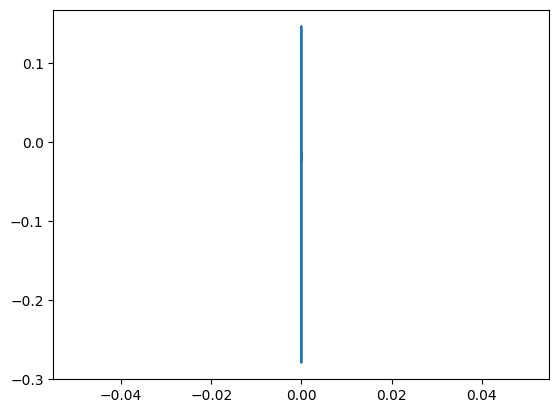

In [256]:
root_dir = "/Users/silas/work/projects/stock_market/data_dump"
stock_data = StockDataset(root_dir, seq_len=1124, mode="relative")

stock_nr = 3

print(stock_data.files)
plt.plot(stock_data.data[stock_nr,-1,:], stock_data.data[stock_nr,0,:])

#abs_data = stock_data.recons_absol()
#plt.plot(abs_data[stock_nr,-1,:], abs_data[stock_nr,0,:])

#average = stock_data.average()
#plt.plot(average[stock_nr,-1,:], average[stock_nr,1,:])

In [257]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, target_stock_idx):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return self.data.shape[-1] - self.seq_len

    def __getitem__(self, idx):
        x = self.data[:, :, idx : idx + self.seq_len]
        y = self.data[:, target_stock_idx, idx + self.seq_len]
        return x, y

In [258]:
def split_time_series(data, train_ratio=0.7, val_ratio=0.15):
    time_steps = data.shape[-1]
    #print(f"Time steps: {time_steps}")
    train_end = int(time_steps * train_ratio)
    val_end = int(time_steps * (train_ratio + val_ratio))
    return data[:, :, 0:train_end], data[:, :, train_end:val_end], data[:, :, val_end:]

In [259]:
def get_warmup_cosine_scheduler(optimizer, warmup_steps, total_steps, lr_max):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return current_step / warmup_steps
        else:
            progress = (current_step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1 + math.cos(math.pi * progress))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

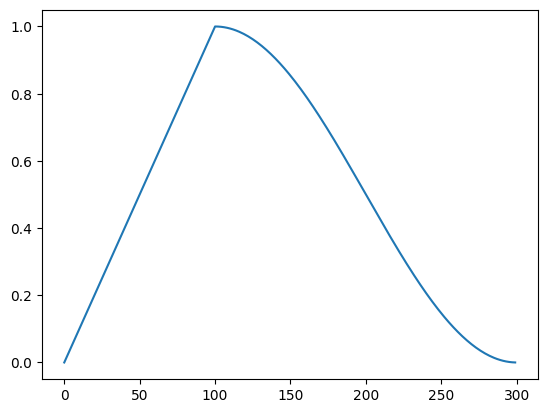

In [260]:
dummy_warmup_steps = 100
dummy_total_steps = 300
dummy_lr = np.zeros(dummy_total_steps)
dummy_steps = np.arange(0, dummy_total_steps, 1)

for step in dummy_steps:
    if step < dummy_warmup_steps:
        dummy_lr[step] = step / dummy_warmup_steps
    else:
        progress = (step - dummy_warmup_steps) / (dummy_total_steps - dummy_warmup_steps)
        dummy_lr[step] = 0.5 * (1 + math.cos(math.pi * progress))

plt.plot(dummy_steps, dummy_lr)
plt.show()

In [261]:
in_size = len(stock_data.files)
data_pass = stock_data.data[:,0:6,:]
target_stock_idx = 1 # [open, close, high, low, volume, datetime]
print(f"Stock dimension: {stock_data.data.shape}")
value_size = data_pass.shape[1]
print(f"Value size: {value_size}")

h_size = 16
n_layers = 3
n_heads = 2
dropout = 0.1
seq_len = 32
batch_size = 32

warmup_steps = 100
total_steps = 300
lr_max=5e-6

threshold = 5e-2
deviation = (1.0, 0.0)

Stock dimension: (22, 10, 1124)
Value size: 6


In [262]:
train, val, test = split_time_series(data_pass, train_ratio=0.8, val_ratio=0.1)
print(f"Shapes: train={train.shape} val={val.shape} test={test.shape}")

train_ds = TimeSeriesDataset(train, seq_len, target_stock_idx)
val_ds = TimeSeriesDataset(val, seq_len, target_stock_idx)
test_ds = TimeSeriesDataset(test, seq_len, target_stock_idx)
#print(f"Shapes: train={train.shape} val={val.shape} test={test.shape}")

# (Batch, in_size, seq_len)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

Shapes: train=(22, 6, 899) val=(22, 6, 112) test=(22, 6, 113)


In [263]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
print(f"device: {device}")

device: cpu


In [264]:
model = LSTM(in_size, h_size, n_layers, batch_size, seq_len, n_heads, value_size=value_size, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_max)
scheduler = get_warmup_cosine_scheduler(optimizer, warmup_steps=warmup_steps, total_steps=total_steps, lr_max=lr_max)

In [265]:
def calc_correct_preds(test_data, mu, sigma, nu, threshold):

    sigma = np.where(nu > 2, np.sqrt(nu / (nu-2)) * sigma, 1e10)
    
    # signal to noise ratio
    s_n = np.abs(mu) / sigma

    significant_out = np.where(s_n > threshold, np.where(mu > 0, 1, -1), 0.)

    samples = np.sum((significant_out * test_data) != 0)
    correct_sign = np.sum((significant_out * test_data) > 0.)

    return samples, correct_sign

In [266]:
for step in range(total_steps):
    
    # Training
    model.train()
    train_loss = 0
    
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        mu, sigma, nu = model(batch_x)
        loss = loss_fn(mu, sigma, nu, batch_y, deviation)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    scheduler.step()
    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0

    samples = 0
    correct_sign = 0
    
    for val_x, val_y in val_loader:
        val_x = val_x.to(device)
        val_y = val_y.to(device)

        mu, sigma, nu = model(val_x)
        loss = loss_fn(mu, sigma, nu, val_y, deviation)

        val_loss += loss.item()

        # <=== Test correct up down predictions ===>
        val_y = val_y.to("cpu").detach().numpy()
        sigma = sigma.to("cpu").detach().numpy()
        mu = mu.to("cpu").detach().numpy()
        nu = nu.to("cpu").detach().numpy()

        sam, corr = calc_correct_preds(val_y, mu, sigma, nu, threshold)
        samples += sam
        correct_sign += corr

    avg_val_loss = val_loss / len(val_loader)
    correct_sign_ratio = correct_sign / samples

    if (step % 5 == 4):
        print(f"Step              : {step+1}/{total_steps}")
        print(f"LR in millions    : {scheduler.get_last_lr()[0]*10e6:.3f}")
        print(f"Train Loss        : {avg_train_loss:.4f}")
        print(f"Validation Loss   : {avg_val_loss:.4f}")
        print(f"Correct sign ratio: {correct_sign_ratio*100:.1f}%")
        print(f"Significant points: {samples}")
        print()

/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_9127/3976003858.py:3: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.where(nu > 2, np.sqrt(nu / (nu-2)) * sigma, 1e10)
/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_9127/3773453364.py:50: RuntimeWarning: invalid value encountered in scalar divide
  correct_sign_ratio = correct_sign / samples


Step              : 5/300
LR in millions    : 2.500
Train Loss        : 781.6361
Validation Loss   : 674.1791
Correct sign ratio: nan%
Significant points: 0

Step              : 10/300
LR in millions    : 5.000
Train Loss        : 781.3504
Validation Loss   : 673.9118
Correct sign ratio: nan%
Significant points: 0

Step              : 15/300
LR in millions    : 7.500
Train Loss        : 780.8372
Validation Loss   : 673.4491
Correct sign ratio: nan%
Significant points: 0

Step              : 20/300
LR in millions    : 10.000
Train Loss        : 780.0780
Validation Loss   : 672.7709
Correct sign ratio: nan%
Significant points: 0

Step              : 25/300
LR in millions    : 12.500
Train Loss        : 779.0176
Validation Loss   : 671.8266
Correct sign ratio: nan%
Significant points: 0

Step              : 30/300
LR in millions    : 15.000
Train Loss        : 777.5568
Validation Loss   : 670.5250
Correct sign ratio: nan%
Significant points: 0

Step              : 35/300
LR in millions   

In [267]:
# Test
correct_sign = 0
samples = 0

# Create plot for number of correct predictions dependent on threshold values
#threshold = np.arange(0., 1e-1, 10000)

for test_x, test_y in test_loader:
    test_x = test_x.to(device)
    test_y = test_y.to(device)
    
    mu, sigma, nu = model(test_x)

    """
    if epoch == num_epochs - 1:
        model.train()
        optimizer.zero_grad()
        loss = loss_fn(mu, sigma, nu, test_y, deviation)
        loss.backward()
        optimizer.step()
        model.eval()
    """

    test_y = test_y.to("cpu").detach().numpy()
    mu = mu.to("cpu").detach().numpy()
    sigma = sigma.to("cpu").detach().numpy()
    nu = nu.to("cpu").detach().numpy()

    sam, corr = calc_correct_preds(test_y, mu, sigma, nu, threshold)
    samples += sam
    correct_sign += corr
    
correct_sign_ratio = correct_sign / samples

print(f" <========== Test ==========>")
print(f"Correct sign ratio: {correct_sign_ratio*100:.1f}%")
print(f"Significant points: {samples}")
print(f"nu mean: {nu.mean():.1f} max: {nu.max():.1f} min: {nu.min():.1f}")

 <========== Test ==========>
Correct sign ratio: 55.6%
Significant points: 597
nu mean: 17.4 max: 42.0 min: 9.3
